# PySP开发测试区

## 0. 测试准备

### 0.1 测试环境导入

In [1]:
import numpy as np
from numpy import random
from scipy.io import loadmat
import os

### 0.2 测试数据导入

> 测试数据1: 故障轴承振动信号

In [2]:
from CXG_bearing import CXG_readData

res = CXG_readData(
    type="外圈",
    level="0.5",
    fr="1500",
    load="0.4",
    FileLoc=r"F:\OneDrive\用户文件\科研学习\故障诊断数据库\CXG_bearing",
)
Data = res["数据/通道1"][0]

尝试读取文件路径: F:\OneDrive\用户文件\科研学习\故障诊断数据库\CXG_bearing\外圈\0.5\1500\0.4\
读取成功


## 1. Signal模块测试

### 1.1 Signal.Signal()

Signal(data=[ 0.32727673  1.63924196  1.63400172 ...  0.8546353   0.20008184
 -1.64591135], label=测试信号, fs=12000)


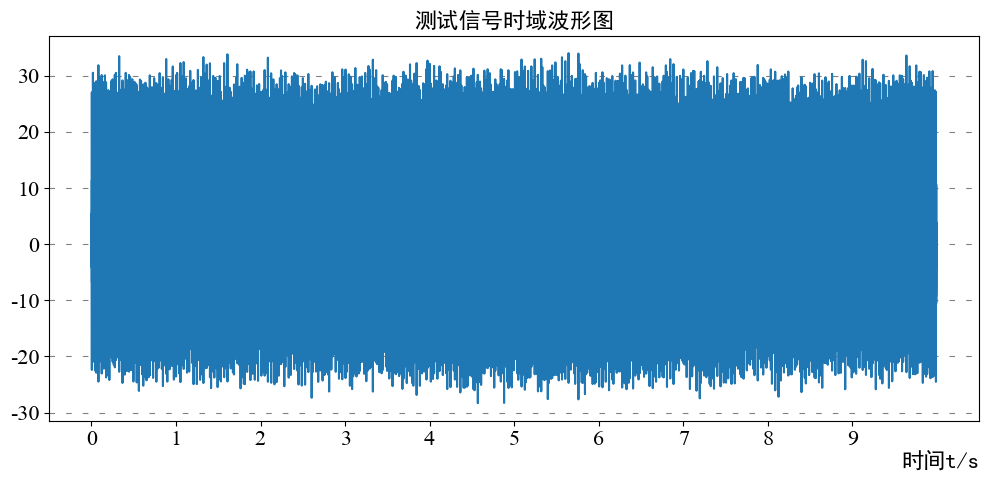

In [12]:
from PySP.Signal import Signal

try:
    res = Signal(data=Data,label='测试信号',fs=12000)
    print(repr(res))
    res.plot()
except Exception as e:
    print(e)

### 1.2 Signal.resample()

Signal(data=[ 30.10136048   2.18899064 -23.58345626 ...  11.99252455   6.84661011
  -5.25691223], label=重采样测试信号, fs=6000.0)


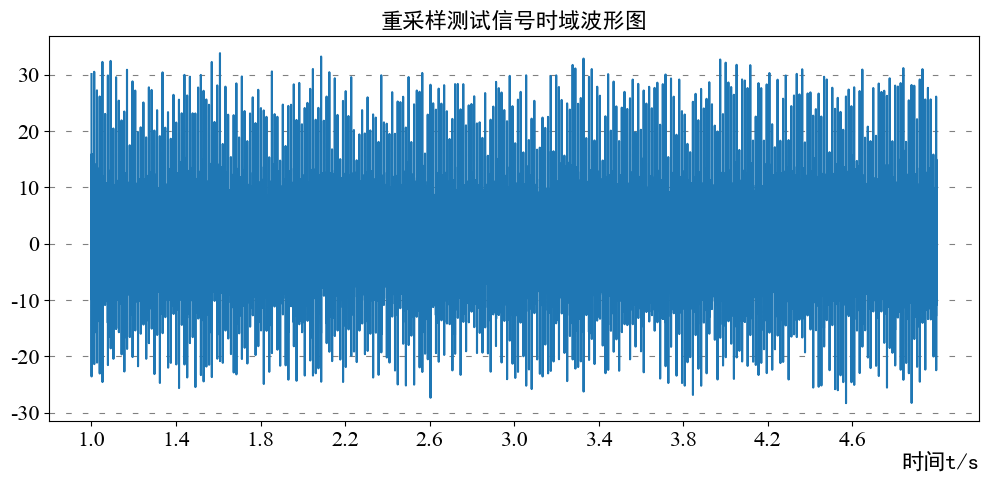

In [5]:
from PySP.Signal import resample

try:
    res = Signal(data=Data,label='测试信号',fs=12000)
    res=resample(Sig=res,down_fs=6000,t0=1,T=4)
    print(repr(res))
    res.plot()
except Exception as e:
    print(e)

### 1.3 Signal.Sig_Periodic()

Signal(data=[1.33422336 1.23406143 1.07538896 ... 1.27252759 1.34965744 1.37228561], label=仿真含噪准周期信号, fs=1000)


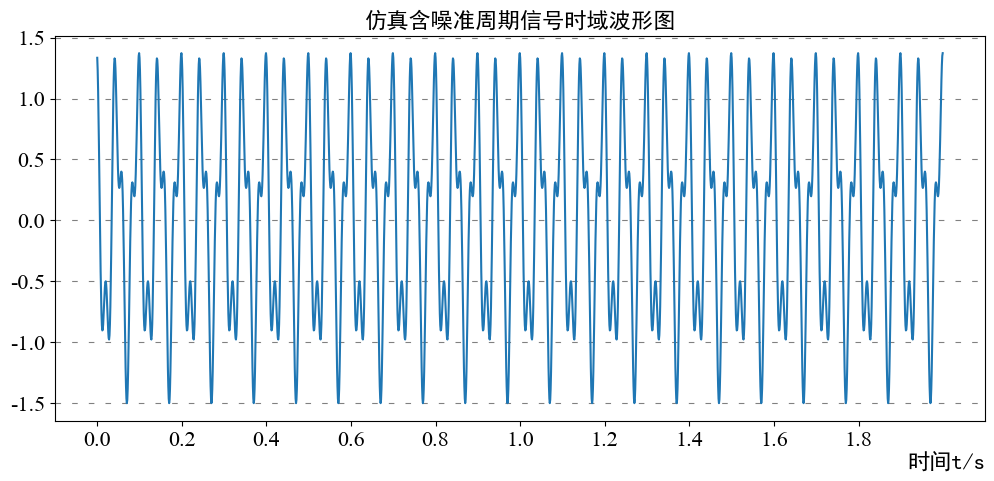

In [6]:
from PySP.Signal import Sig_Periodic

try:
    res = Sig_Periodic(fs=1000,T=2,CosParams=((20,1,32),(50,0.5,0)))
    print(repr(res))
    res.plot()
except Exception as e:
    print(e)

### 1.4 Signal.Analysis()

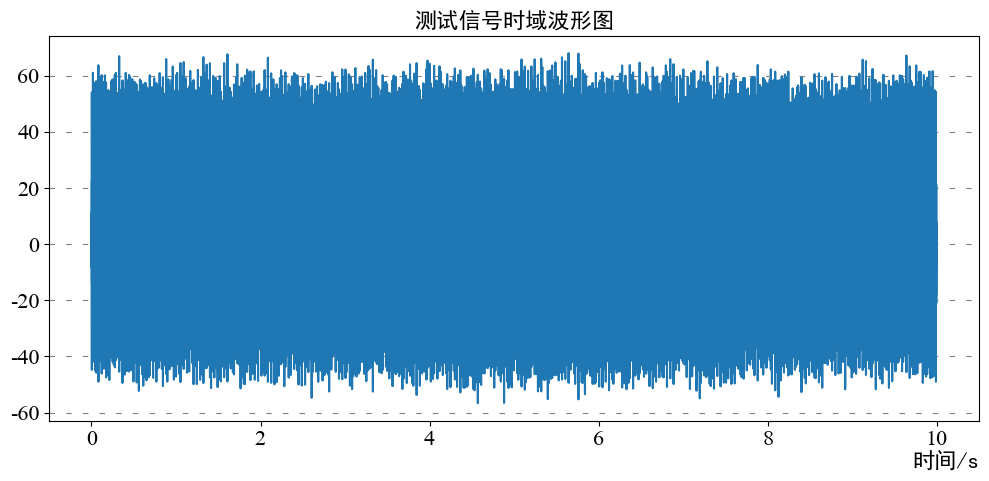

In [23]:
from PySP.Signal import Signal, Analysis
from PySP.Plot import plot_spectrum

try:
    class TestAnalysis(Analysis):
        def __init__(
            self,
            Sig: Signal,
            plot: bool = False,
            plot_save: bool = False,
            **kwargs,
        ):
            super().__init__(Sig=Sig, plot=plot, plot_save=plot_save, **kwargs)

        @Analysis.Plot(plot_func=plot_spectrum)
        @Analysis.Input({"x": {}})
        def run(self, x: float):
            t_Axis=self.Sig.t_Axis
            data=self.Sig.data*x
            return t_Axis,data

    Sig=Signal(data=Data,label='测试信号',fs=12000)
    res = TestAnalysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        xlabel="时间/s",
        title="测试信号时域波形图"
    ).run(x=2)

except Exception as e:
    print(e)

## 2. Plot模块测试

In [7]:
data_list = []
for i in range(10):
    data = random.randn(len(t))
    data_list.append(data)
dataArray = np.array(data_list)
plot_2D_Anim(
    t,
    dataArray,
    xlabel="时间t(s)",
    ylabel="幅值",
    framelabel=[f"第{i+1}次实验" for i in range(len(dataArray))],
    frameFps=10,
    linecolor="black",
)